In [68]:
from scope_utils import set_scope, get_waveform, get_trace_data, TraceData
import pyvisa
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import h5py
import time
import tqdm
from typing import List, Tuple, Sequence
from utils_dBm import dBm_to_Vpp, Vpp_to_dBm, Vpp_to_Vrms, Vrms_to_watt
import csv

plt.rcParams.update({'font.size': 14})

In [2]:
rm = pyvisa.ResourceManager()

scope: pyvisa.resources.USBInstrument = rm.open_resource("USB0::0x1AB1::0x04CE::DS1ZA242902611::INSTR", read_termination = "\n")
fng: pyvisa.resources.USBInstrument = rm.open_resource("USB0::0xF4ED::0xEE3A::446B18102::INSTR", read_termination = "\n")

## Initialize function generator settings

In [3]:
channel = 1
fng.write(f"C{channel}:BSWV WVTP,SINE")
fng.write(f"C{channel}:BSWV FRQ,1e6")
fng.write(f"C{channel}:BSWV AMP,1")
fng.write(f"C{channel}:BSWV OFST,0")
fng.write(f"C{channel}:OUTP ON, LOAD, 50, PLRT,NOR")

32

## Initialize scope settings

In [4]:
time_div = 5e-7
t_offset = 0
offset = 0

channel = 1
scope.write(f":CHAN{channel}:DISP 1")
channel = 2
scope.write(f":CHAN{channel}:DISP 1")

set_scope(scope, 1, 50e-3, offset, time_div, t_offset)
set_scope(scope, 2, 50e-3, offset, time_div, t_offset)


scope.write(":START")
scope.write(":ACQ:MDEP 6000")

16

In [5]:
def select_scale(scale: float) -> float:
    scale_steps = np.ravel([np.array([5,2,1]) * 10**x for x in np.linspace(1,-3,5)])[2:]
    if scale < 1e-3:
        scale_select = 1e-3
    else:
        for ids,s in enumerate(scale_steps):
            if scale >= s:
                scale_select = scale_steps[ids-1]
                break
    return scale_select

In [6]:
def get_trace(
    scope: pyvisa.resources.USBInstrument, channels: Sequence[int]
) -> TraceData:
    scope.write(":SINGLE")
    while True:
        if scope.query(":TRIG:STAT?") == "STOP":
            break
        time.sleep(0.05)
    trace = get_trace_data(scope, channels)
    scope.write(":CLEAR")
    return trace


In [14]:
# while True:
#     scope.read_raw(1000)

bidirectional coupler input coupling is 20 dB

In [15]:
# there are 8 divisions
ndiv = 8
fng_channel = 1
channel_transmission = 1
channel_reflection = 2

amplitude = 5
fng.write(f"C{fng_channel}:BSWV AMP,{amplitude}")

scale_ch1 = dBm_to_Vpp(Vpp_to_dBm(amplitude) - 20) / ndiv
scale_ch1 = select_scale(scale_ch1)
scope.write(f":CHAN{channel_transmission}:SCAL {scale_ch1}")
scope.write(f":CHAN{channel_reflection}:SCAL {scale_ch1}")

current_scale = float(scope.query(f":CHAN{channel_reflection}:SCAL?"))

fng.write(f"C{fng_channel}:OUTP ON, LOAD, 50, PLRT,NOR")
scope.write(":CLEAR")

scan_data: List[Tuple[float, TraceData]] = []
for frequency in tqdm.tqdm(np.linspace(1.55e6,1.65e6,101)):
    fng.write(f"C{fng_channel}:BSWV FRQ,{frequency}")
    trace = get_trace(scope, [channel_transmission, channel_reflection])
    ptp = trace.reflection.ptp()
    scope.write(f":CHAN{channel_reflection}:SCAL {ptp/ndiv * 1.2}")
    trace = get_trace(scope, [channel_transmission,channel_reflection])
    scope.write(f":CHAN{channel_reflection}:SCAL {scale_ch1}")
    scan_data.append((frequency, trace))


fng.write(f"C{fng_channel}:BSWV AMP 0")
fng.write(f"C{fng_channel}:OUTP OFF, LOAD, 50, PLRT,NOR")

100%|██████████| 101/101 [03:10<00:00,  1.89s/it]


33

In [16]:
processed_data: List[Tuple[float, float]] = []
for f, trace in scan_data:
    processed_data.append((f, trace.reflection.ptp()/trace.transmission.ptp()))

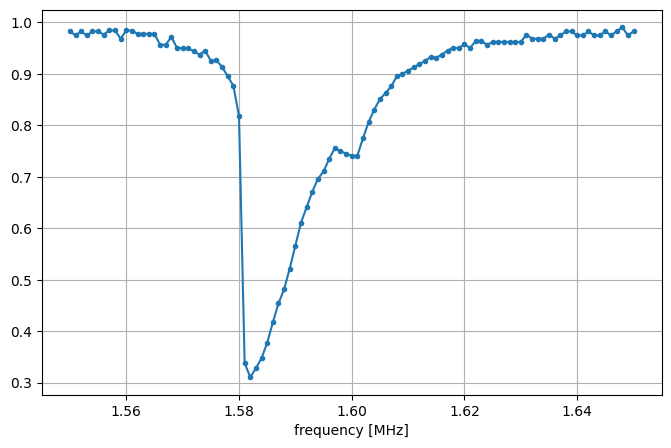

In [17]:
x,y = np.asarray(list(zip(*processed_data)))

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(x/1e6,y,'.-')
ax.set_xlabel("frequency [MHz]")
ax.grid(True)

## Scan Amplitude and Frequency

In [18]:
# there are 8 divisions
ndiv = 8
fng_channel = 1
channel_transmission = 1
channel_reflection = 2

scan_data: List[Tuple[float, float, float, float]] = []

fng.write(f"C{fng_channel}:OUTP ON, LOAD, 50, PLRT,NOR")
scope.write(":CLEAR")
for amplitude in tqdm.tqdm(np.linspace(0.05, 10, 91)):
    fng.write(f"C{fng_channel}:BSWV AMP,{amplitude}")

    scale_ch1 = dBm_to_Vpp(Vpp_to_dBm(amplitude) - 20) / ndiv
    scale_ch1 = select_scale(scale_ch1)
    scope.write(f":CHAN{channel_transmission}:SCAL {scale_ch1}")
    scope.write(f":CHAN{channel_reflection}:SCAL {scale_ch1}")

    for frequency in np.linspace(1.55e6, 1.65e6, 151):
        fng.write(f"C{fng_channel}:BSWV FRQ,{frequency}")
        trace = get_trace(scope, [channel_transmission, channel_reflection])
        ptp = trace.reflection.ptp()
        scope.write(f":CHAN{channel_reflection}:SCAL {ptp/ndiv * 1.2}")
        trace = get_trace(scope, [channel_transmission, channel_reflection])
        scope.write(f":CHAN{channel_reflection}:SCAL {scale_ch1}")
        scan_data.append(
            (amplitude, frequency, trace.reflection.ptp() / trace.transmission.ptp())
        )

fng.write(f"C{fng_channel}:BSWV AMP,0")
fng.write(f"C{fng_channel}:OUTP OFF, LOAD, 50, PLRT,NOR")


100%|██████████| 91/91 [7:12:37<00:00, 285.24s/it]  


33

In [19]:
with open("2023_2_9_DET_PHASE_EOM_SCAN.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(["amplitude [Vpp]", "frequency [Hz]", "reflection/transmission"])
    for row in scan_data:
        writer.writerow(row)

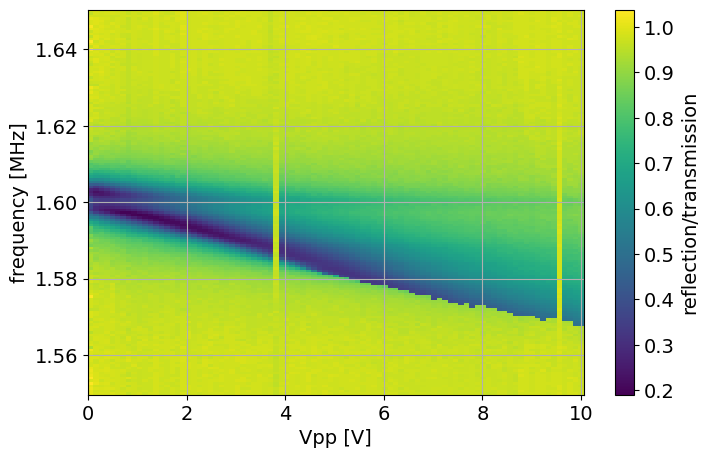

In [70]:
x,y,z = np.asarray(list(zip(*scan_data)))

x = np.reshape(x, (91,151))
y = np.reshape(y, (91,151)) / 1e6
z = np.reshape(z, (91,151))

fig, ax = plt.subplots(figsize = (8,5))
c = ax.pcolormesh(x,y,z)
ax.set_xlabel("Vpp [V]")
ax.set_ylabel("frequency [MHz]")

cbar = fig.colorbar(c)
cbar.ax.set_ylabel("reflection/transmission")
ax.grid(True)

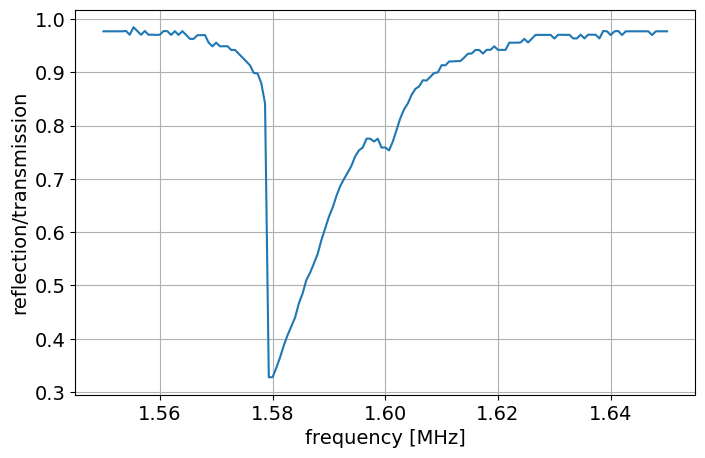

In [71]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(y[51,:], z[51,:])

ax.set_xlabel("frequency [MHz]")
ax.set_ylabel("reflection/transmission")
ax.grid(True)

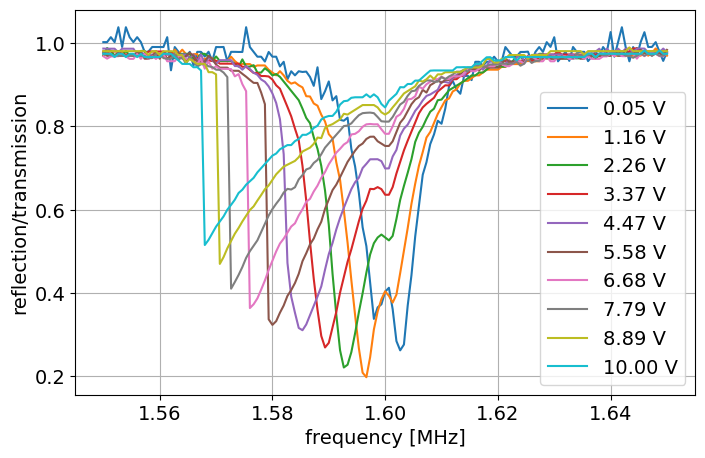

In [72]:
select = np.s_[::10,:]
fig, ax = plt.subplots(figsize = (8,5))

labels = [f"{val:.2f} V" for val in x[select][:,0]]
ax.plot(y[select].T, z[select].T, label = labels)

ax.set_xlabel("frequency [MHz]")
ax.set_ylabel("reflection/transmission")
ax.legend()
ax.grid(True)

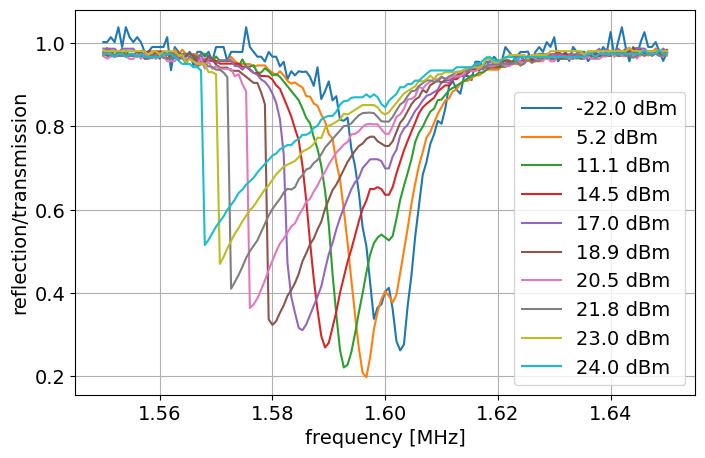

In [73]:
select = np.s_[::10,:]
fig, ax = plt.subplots(figsize = (8,5))

labels = [f"{Vpp_to_dBm(val):.1f} dBm" for val in x[select][:,0]]
ax.plot(y[select].T, z[select].T, label = labels)

ax.set_xlabel("frequency [MHz]")
ax.set_ylabel("reflection/transmission")
ax.legend()
ax.grid(True)

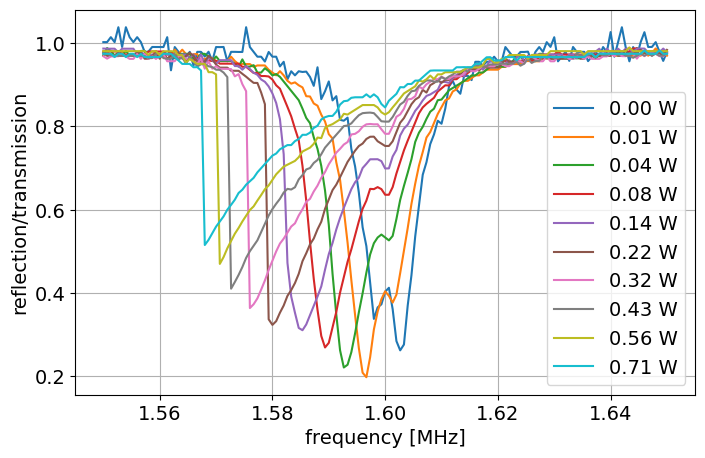

In [74]:
select = np.s_[::10,:]
fig, ax = plt.subplots(figsize = (8,5))

labels = [f"{Vpp_to_Vrms(Vrms_to_watt(val)):.2f} W" for val in x[select][:,0]]
ax.plot(y[select].T, z[select].T, label = labels)

ax.set_xlabel("frequency [MHz]")
ax.set_ylabel("reflection/transmission")
ax.legend()
ax.grid(True)

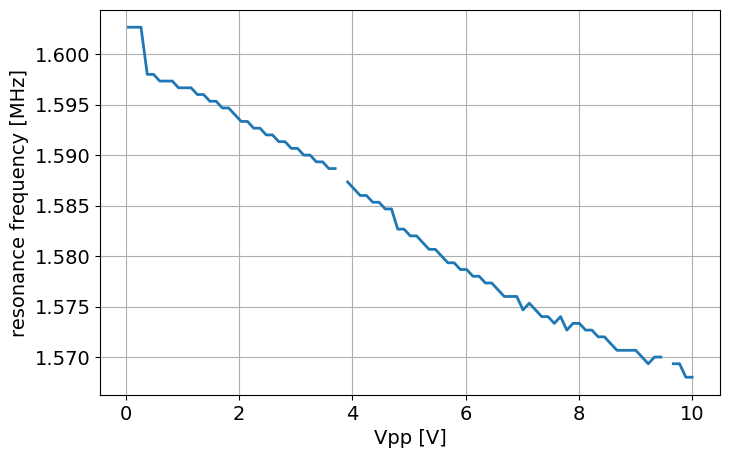

In [84]:
freq_res = y[0,np.argmin(z, axis = 1)]
freq_res[freq_res < 1.56] = np.nan

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(x[:,0], freq_res, lw = 2)

ax.set_xlabel("Vpp [V]")
ax.set_ylabel("resonance frequency [MHz]")
ax.grid(True)